# NBA 2023: Predicting the Winners of the Western and Eastern Conference
Corbin Cahalan

Every year, millions of people around the world tune in to watch their favorite NBA teams. Wouldn't it be great if you could predict how well your team will do in the 2022-2023 season? With our supervised models below, we attempt to predict how each team stacks up against the rest. 

In [1]:
## library imports

# api libraries
import requests
from time import sleep
from datetime import date

# data manipulation and visualization libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import functools as ft

# supervised learning libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

!pip install xgboost
import xgboost as xgb

     |████████████████████████████████| 255.9 MB 144 kB/s s eta 0:00:01


## Data Extraction

In order to create our supervised learning model, we extracted data using the <a target="_blank" href="https://www.balldontlie.io/">balldontlie API</a> for historical data and <a href="https://www.basketball-reference.com/leagues/NBA_2023_games.html" targe="_blank">Basketball Reference</a> for 2023 season games. To predict how many regular season games each team will win in the 2022-2023 season, we chose to grab the last 7 seasons' worth of data. This way, we have enough games (rows of data) to work with as input for our supervised learning model.

### API Function for Historical Games and Stats Data

To make calls to the balldontlie API efficiently for historical games and stats data, we've created a function that takes the API URL, seasons, and a few other inputs to extract the appropriate data.

In [ ]:
def get_api_data(api_url, post_season=False, num_seasons=7, per_page=100, api_note=10):
    
    # get seasons string
    year_strings_list = []
    for num in range(num_seasons):
        year_strings_list.append("seasons[]="+str(int(date.today().year) - (num+1)))
    
    seasons = '&'.join(map(str, year_strings_list))
    
    # get full api url
    full_url = str(api_url) + "?postseason=" + str(post_season) + "&per_page=" + str(per_page) + "&" + seasons
    
    # make first api call
    response = requests.get(full_url,verify=False)
    data = response.json()
    
    
    total_results = [] #initialize with empty list
    total_results = total_results + data['data'] #first page of results
    
    print("Downloading API data from",str(full_url))
    # Loop through API pages for full dataset
    
    while data['meta']['next_page'] is not None:
        next_page = "page="+str(data['meta']['next_page'])
        next_api_url = full_url+"&"+next_page
        response = requests.get(next_api_url,verify=False)
        data = response.json()
        
        # Store the current page of results
        total_results = total_results + data['data']
        
        #print a line each 10 pages that have been collected
        try:
            if data['meta']['next_page'] % api_note == 0:
                print("Have collected all pages up to page", data['meta']['next_page'])
        except:
            pass
        
        #add a second break to slow down your api request
        sleep(1)
        
    print("Received", len(total_results), "total results")
    
    return pd.json_normalize(total_results)

#### Get Game Data for 2015-2021 NBA Seasons

The <a href="https://www.balldontlie.io/#games" target="_blank">games API</a> allows us to collect the high level game points per team. Using this API, we can extract which team won a game, whether the winning team was the home or visiting team, and a few other fields.

In [ ]:
game_api = "https://www.balldontlie.io/api/v1/games"

In [ ]:
regular_season_games = get_api_data(game_api, post_season=False, num_seasons=7, per_page=100, api_note=10)

In [ ]:
regular_season_games.head()

In [ ]:
regular_season_games.columns

In [ ]:
#create a csv to save api results
regular_season_games.to_csv('regular_season_games.csv')

#### Get Player Statistics per Game from 2015-2021 NBA Seasons

The <a href="https://www.balldontlie.io/#stats" target="_blank">stats API</a> allows us to collect the player-level stats per game. Using this API, we can transform player-level stats into team-level stats per game, such as team 3-point percentage, team number of steals or rebounds, and so on.

In [ ]:
stats_api = "https://www.balldontlie.io/api/v1/stats"

In [ ]:
regular_season_stats = get_game_data(stats_api, post_season=False, num_seasons=7, per_page=100, api_note=100)

In [ ]:
regular_season_stats.head()

In [ ]:
regular_season_stats.columns

In [ ]:
#create a csv to save api results
regular_season_stats.to_csv('regular_season_stats.csv')

#### Get Team Info

We will also need a table with each team's name, team id, etc. This will be useful post-prediction for adding team ids to each 2023 game. The <a href="https://www.balldontlie.io/#teams" target="_blank">teams API</a> allows us to collect this info. Because there are only 30 teams in the NBA, we can just do a simple API call without the API function created above. The only caveat is that the API has a different name for the LA Clippers, so we just need to replace the name with what is used by <a href="https://www.basketball-reference.com/leagues/NBA_2023_games.html" targe="_blank">Basketball Reference</a> (our source for 2023 season games info).

In [ ]:
teams_api = 'https://www.balldontlie.io/api/v1/teams'
response = requests.get(teams_api,verify=False)
data = response.json()
team_info = pd.json_normalize(data['data'])

#adjust the name of the LA Clippers from the API to match with Los Angeles Clippers from Basketball Reference
team_info_cleaned = team_info.replace("LA Clippers", "Los Angeles Clippers")

In [ ]:
team_info_cleaned.head()

In [ ]:
team_info_cleaned.columns

In [ ]:
#create a csv to save api results
team_info_cleaned.to_csv('team_info.csv')

#### Get 2023 Games Schedule

I was able to download this season's games from <a href="https://www.basketball-reference.com/leagues/NBA_2023_games.html" targe="_blank">Basketball Reference</a>. No scraping or API calls needed.


In [2]:
games_2023 = pd.read_csv('games_2023.csv')

#rename columns to be more user friendly
games_2023.rename(columns={"Date": "date","Start (ET)":"time_et","Visitor/Neutral":"away_team",
                           "Home/Neutral":"home_team"}, inplace=True)

In [3]:
games_2023.head()

,date,time_et,away_team,home_team
0,Wed Oct 26 2022,8:00p,San Antonio Spurs,Minnesota Timberwolves
1,Wed Oct 26 2022,7:30p,Philadelphia 76ers,Toronto Raptors
2,Wed Oct 26 2022,7:00p,Orlando Magic,Cleveland Cavaliers
3,Wed Oct 26 2022,10:00p,Miami Heat,Portland Trail Blazers
4,Wed Oct 26 2022,10:00p,Los Angeles Lakers,Denver Nuggets


In [4]:
len(games_2023)

1230

## Choosing Features

For our models, we decided that we wanted to use the following features for model prediction (along with our assumptions):
<ol>
    <li>Home and Away Team IDs: distinguish who is playing against each other</li>
    <li>Season: this feature likely won't do much, but can potentially have some influence</li>
    <li>Team 3-point Percentage: if a team is good at making 3s, they have a strong offense</li>
    <li>Team field goal Percentage: if a team has a good field goal perecentage, this also contributes to strong offense</li>
    <li>Team Free-throw Percentage: Not as important as 3-point and field goals, but also contributes to offense</li>
    <li>Team Assists: if a team has a lot of assists, they're good at moving the ball around to make shots</li>
    <li>Team Blocks: if a team has a lot of blocks, they are good a defending shots</li>
    <li>Defensive Rebounds: if a team is good at defensive rebounds, they reduce the odds that the other team has more opportunities to score.</li>
    <li>Steals: another feature that can indicate defensive strength</li>
    

In [5]:
#the columns we need to eventually calculate the features
stats_columns = ['game.id','game.season','team.id', #ids
                 'ast', 'fg3a', 'fg3m', 'fga','fgm', 'fta', 'ftm', #offense stats
                 'stl','blk', 'dreb'] #defense stats

final_features = ['home_team_id','away_team_id','season',
                  'home_fg3pct','home_fgpct','home_ftpct','away_fg3pct','away_fgpct','away_ftpct',
                  'home_ast', 'home_blk', 'home_dreb', 'home_stl','away_ast', 'away_blk', 'away_dreb', 'away_stl',
                  'home_team_won']

input_2023 = ['home_team_id','away_team_id','season',
              'home_fg3pct','home_fgpct','home_ftpct','away_fg3pct','away_fgpct','away_ftpct',
              'home_ast_avg', 'home_blk_avg', 'home_dreb_avg', 'home_stl_avg','away_ast_avg', 'away_blk_avg', 'away_dreb_avg', 'away_stl_avg',]


## Data Manipulation & Cleaning

Now that we have our four datasets, we need to combine them into two: one for historical data and one for 2023 data. We will...
<ol>
    <li><b>Create the Supervised Learning Model Dataset:</b> Sum/Average the stats per team per game from the stats API data and join it to the games API data. This will enable us to use many features in our models.</li>
    <li><b>Create the Inputs Dataset for 2023 Prediction:</b> Combine the teams API data with the Basketball Reference 2023 schedule to add the team id columns. Then, use the stats API dataset to join average stats for prediction.</li>
</ol>

### Get Final Historical Games Dataset

In [6]:
#read in CSV data from API data extraction
regular_season_stats_csv = pd.read_csv('regular_season_stats.csv', index_col=0)
regular_season_games_csv = pd.read_csv('regular_season_games.csv', index_col=0)

In [7]:
# feature #1: create boolean column whether the home team won
def winner_column(df):
    df['home_team_won'] = np.where(df.home_team_score > df.visitor_team_score,1,0)
    return df

In [8]:
games_df = winner_column(regular_season_games_csv)

#### Separate Home Team Columns and Away Team Columns into two datasets

In [9]:
home_columns = ['id','season','home_team_score','home_team.id','home_team_won']
away_columns = ['id','season','visitor_team_score','visitor_team.id']

In [10]:
home_team_df = games_df[home_columns]
away_team_df = games_df[away_columns]

#### Aggregate Player Stats per Game

In [11]:
def agg(df):
    agg_df = df.groupby(['game.id','team.id','game.season']
                   ).sum().reset_index()
    
    return agg_df[stats_columns]

In [12]:
stats_df = agg(regular_season_stats_csv)

In [13]:
stats_df.head()

,game.id,game.season,team.id,ast,fg3a,fg3m,fga,fgm,fta,ftm,stl,blk,dreb
0,152,2018,5,16.0,33.0,8.0,89.0,35.0,22.0,20.0,11.0,3.0,37.0
1,152,2018,7,18.0,33.0,10.0,79.0,37.0,29.0,19.0,11.0,7.0,42.0
2,153,2018,20,18.0,26.0,7.0,88.0,39.0,23.0,18.0,8.0,8.0,27.0
3,153,2018,21,32.0,33.0,16.0,95.0,51.0,12.0,10.0,11.0,7.0,34.0
4,160,2018,15,16.0,30.0,11.0,103.0,45.0,15.0,11.0,9.0,3.0,30.0


#### Join stat_df to home_team_df and away_team_df

In [14]:
home_team_df.sort_values(by=['id','season']).head()

,id,season,home_team_score,home_team.id,home_team_won
363,1,2018,105,2,1
364,2,2018,108,10,1
365,3,2018,112,4,0
366,4,2018,103,9,1
367,5,2018,111,12,1


In [15]:
stats_df.sort_values(by=['game.id','game.season']).head()

,game.id,game.season,team.id,ast,fg3a,fg3m,fga,fgm,fta,ftm,stl,blk,dreb
0,152,2018,5,16.0,33.0,8.0,89.0,35.0,22.0,20.0,11.0,3.0,37.0
1,152,2018,7,18.0,33.0,10.0,79.0,37.0,29.0,19.0,11.0,7.0,42.0
2,153,2018,20,18.0,26.0,7.0,88.0,39.0,23.0,18.0,8.0,8.0,27.0
3,153,2018,21,32.0,33.0,16.0,95.0,51.0,12.0,10.0,11.0,7.0,34.0
4,160,2018,15,16.0,30.0,11.0,103.0,45.0,15.0,11.0,9.0,3.0,30.0


In [16]:
#columns to drop
drop_columns = {'game.id','game.season','team.id'}

#columns to rename
home_rename_columns = {'id':'game_id','home_team.id':'home_team_id','ast': 'home_ast', #ids and assists
                       'fg3a': 'home_fg3a','fg3m': 'home_fg3m', #3s
                       'fga': 'home_fga','fgm': 'home_fgm', #fgs
                       'fta': 'home_fta','ftm': 'home_ftm', #fts
                       'blk': 'home_blk','dreb': 'home_dreb','stl': 'home_stl'} #defense

away_rename_columns = {'id':'game_id','visitor_team.id':'away_team_id', #ids
                       'visitor_team_score':'away_team_score','ast': 'away_ast', #offense
                       'fg3a': 'away_fg3a','fg3m': 'away_fg3m', #3s
                       'fga': 'away_fga','fgm': 'away_fgm', #fgs
                       'fta': 'away_fta','ftm': 'away_ftm', #fts
                       'blk': 'away_blk','dreb': 'away_dreb','stl': 'away_stl'} #defense

home = home_team_df.merge(stats_df, how='left', 
                          left_on=['id','home_team.id'], 
                          right_on=['game.id','team.id']
                         ).rename(columns=home_rename_columns
                         ).drop(columns=drop_columns)


away = away_team_df.merge(stats_df, how='left', 
                          left_on=['id','visitor_team.id'], 
                          right_on=['game.id','team.id']
                          ).rename(columns=away_rename_columns
                          ).drop(columns=drop_columns)


#### Create Final Dataset for Historical Data

In [17]:
historical_games_df = home.merge(away, how='left', on=['game_id','season'])

#### Clean Dataset

after all of the joining, if a row is missing all of the stats for the home and away team, then we'll need to drop it.

In [18]:
len(historical_games_df[historical_games_df.isna().any(axis=1)])

225

In [19]:
len(historical_games_df[historical_games_df.isna().any(axis=1)])/len(historical_games_df)

0.026836832061068704

Only ~2.6% of our dataset needs to be dropped. This is great!

In [20]:
historical_games_df.dropna(subset=final_features[9:-1],how='all',inplace=True)

In [21]:
len(historical_games_df)

8160

Our model will still have more than 8K games to work with. This is a good amount of rows for prediction.

In [22]:
historical_games_df.describe().T

,count,mean,std,min,25%,50%,75%,max
game_id,8160.0,128902.493995,162207.985883,152.0,33276.75,35585.5,127878.25,474638.0
season,8160.0,2017.973039,2.053759,2015.0,2016.00,2018.0,2020.00,2021.0
home_team_score,8160.0,109.255147,12.871282,59.0,101.00,109.0,118.00,161.0
home_team_id,8160.0,15.508824,8.653517,1.0,8.00,16.0,23.00,30.0
home_team_won,8160.0,0.567892,0.495400,0.0,0.00,1.0,1.00,1.0
home_ast,8160.0,25.008088,7.189054,8.0,21.00,24.0,28.00,74.0
home_fg3a,8160.0,31.774632,10.249292,4.0,25.00,31.0,36.00,122.0
home_fg3m,8160.0,11.461520,4.625236,0.0,8.00,11.0,14.00,46.0
home_fga,8160.0,89.765074,17.859369,48.0,82.00,87.0,92.00,246.0
home_fgm,8160.0,41.631740,9.369473,19.0,37.00,40.0,44.00,122.0


It looks like there is one last row in the away stats likely has null values. We'll make sure to drop that before running our models. Looking at the above statistics, it will probably make sense for us to use RobustScaler during preprocessing. This will help us reduce the effect of games with outlier stats.

#### Add Features

In [23]:
def get_features(df):
    df['home_fg3pct'] = df['home_fg3m'] / df['home_fg3a']
    df['away_fg3pct'] = df['away_fg3m'] / df['away_fg3a']
    df['home_fgpct'] = df['home_fgm'] / df['home_fga']
    df['away_fgpct'] = df['away_fgm'] / df['away_fga']
    df['home_ftpct'] = df['home_ftm'] / df['home_fta']
    df['away_ftpct'] = df['away_ftm'] / df['away_fta']
    return df

In [24]:
historical_games_df = get_features(historical_games_df)

In [25]:
historical_games_df.head()

,game_id,season,home_team_score,home_team_id,home_team_won,home_ast,home_fg3a,home_fg3m,home_fga,home_fgm,...,away_ftm,away_stl,away_blk,away_dreb,home_fg3pct,away_fg3pct,home_fgpct,away_fgpct,home_ftpct,away_ftpct
0,47179,2018,126,2,1,68.0,58.0,24.0,180.0,100.0,...,6.0,14.0,10.0,48.0,0.413793,0.325000,0.555556,0.438202,0.875000,0.428571
1,48751,2018,112,2,0,42.0,52.0,18.0,184.0,78.0,...,62.0,12.0,12.0,86.0,0.346154,0.400000,0.423913,0.476190,0.806452,0.775000
2,48739,2018,117,23,1,46.0,44.0,20.0,156.0,78.0,...,24.0,10.0,6.0,64.0,0.454545,0.230769,0.500000,0.489362,0.906250,0.923077
3,48740,2018,119,30,1,70.0,70.0,24.0,184.0,92.0,...,44.0,12.0,6.0,70.0,0.342857,0.315789,0.500000,0.375000,0.937500,0.880000
4,48746,2018,102,26,1,36.0,52.0,18.0,180.0,74.0,...,18.0,12.0,16.0,76.0,0.346154,0.333333,0.411111,0.431818,0.760000,0.473684


In [26]:
historical_games_df.columns

Index(['game_id', 'season', 'home_team_score', 'home_team_id', 'home_team_won',
       'home_ast', 'home_fg3a', 'home_fg3m', 'home_fga', 'home_fgm',
       'home_fta', 'home_ftm', 'home_stl', 'home_blk', 'home_dreb',
       'away_team_score', 'away_team_id', 'away_ast', 'away_fg3a', 'away_fg3m',
       'away_fga', 'away_fgm', 'away_fta', 'away_ftm', 'away_stl', 'away_blk',
       'away_dreb', 'home_fg3pct', 'away_fg3pct', 'home_fgpct', 'away_fgpct',
       'home_ftpct', 'away_ftpct'],
      dtype='object')

### Get Final Dataset for 2023 Schedule

#### Combine teams API data with Basketball Reference 2023 Schedule data.

In [27]:
teams = pd.read_csv('team_info.csv')

In [28]:
team_ids = teams[['full_name','id']]

In [29]:
games_2023_df = games_2023.merge(team_ids, how='left',left_on='away_team',right_on='full_name'
                         ).rename(columns={'id':'away_team_id'}
                         ).merge(team_ids, how='left',left_on='home_team',right_on='full_name'
                         ).rename(columns={'id':'home_team_id'}
                         ).drop(columns=['full_name_x','full_name_y'])

In [30]:
games_2023_df.head()

,date,time_et,away_team,home_team,away_team_id,home_team_id
0,Wed Oct 26 2022,8:00p,San Antonio Spurs,Minnesota Timberwolves,27,18
1,Wed Oct 26 2022,7:30p,Philadelphia 76ers,Toronto Raptors,23,28
2,Wed Oct 26 2022,7:00p,Orlando Magic,Cleveland Cavaliers,22,6
3,Wed Oct 26 2022,10:00p,Miami Heat,Portland Trail Blazers,16,25
4,Wed Oct 26 2022,10:00p,Los Angeles Lakers,Denver Nuggets,14,8


#### Get 7-year percentage stats per team

As input for 2023 prediction, we will assume that each team will perform roughly how they've performed over the last 7 years. Of course, this doesn't work well for some teams that have had major trades, but taking each team's average performance against each other in recent years can probably get us some decent predictions!

In [31]:
name_of_pct_columns = ['home_fg3pct','home_fgpct','home_ftpct',
                       'away_fg3pct','away_fgpct','away_ftpct']

two_column_lists = [['home_fg3m','home_fg3a'],
                    ['home_fgm','home_fga'],
                    ['home_ftm','home_fta'],
                    ['away_fg3m','away_fg3a'],
                    ['away_fgm','away_fga'],
                    ['away_ftm','away_fta']]

In [32]:
def get_pct_stats(data_df, two_column_list, name_of_pct_column):
    df = data_df.groupby(['home_team_id','away_team_id',]).agg({str(two_column_list[0]):sum,
                                                                str(two_column_list[1]):sum})
    df[str(name_of_pct_column)] = df[str(two_column_list[0])]/df[two_column_list[1]]
    return df[str(name_of_pct_column)]


In [33]:
dfs_list = []
for i in range(len(name_of_pct_columns)):
    name_of_pct_column = name_of_pct_columns[i]
    two_column_list = two_column_lists[i]
    dfs_list.append(get_pct_stats(historical_games_df, two_column_list, name_of_pct_column))
    

In [34]:
percentage_features = ft.reduce(lambda left, right: pd.merge(left, right, 
                                                             on=['home_team_id','away_team_id']), dfs_list
                                                            ).reset_index()


In [35]:
percentage_features.head()

,home_team_id,away_team_id,home_fg3pct,home_fgpct,home_ftpct,away_fg3pct,away_fgpct,away_ftpct
0,1,2,0.406162,0.490375,0.789474,0.343318,0.439614,0.806950
1,1,3,0.306569,0.437765,0.761155,0.359338,0.454467,0.730303
2,1,4,0.385714,0.496000,0.735537,0.387580,0.457584,0.759857
3,1,5,0.355789,0.480818,0.795597,0.401460,0.475712,0.785714
4,1,6,0.361446,0.469435,0.796935,0.369748,0.465986,0.731602


Great! We now have our percentage features. We also need to get our 7-year average stats.

#### Get 7-year average stats per team 

In [36]:
#columns for df
columns = ['home_team_id','away_team_id',
                  'home_ast', 'home_blk', 'home_dreb', 'home_stl',
                  'away_ast', 'away_blk', 'away_dreb', 'away_stl']

#get names for avg colums
name_of_avg_columns=[]
for col in columns[2:]:
    name_of_avg_columns.append(col+'_avg')

#avg_df
avg_df = historical_games_df[columns]

In [37]:
average_features = avg_df.groupby(columns[0:2]).mean().reset_index()

In [38]:
for i in range(len(average_features.iloc[:,2:].columns)):
    average_features.rename(columns={str(average_features.iloc[:,2+i:3+i].columns.values[0]):name_of_avg_columns[i]},inplace=True)
    

In [39]:
average_features.head()

,home_team_id,away_team_id,home_ast_avg,home_blk_avg,home_dreb_avg,home_stl_avg,away_ast_avg,away_blk_avg,away_dreb_avg,away_stl_avg
0,1,2,24.833333,5.583333,33.583333,7.500000,23.416667,4.416667,30.750000,8.583333
1,1,3,25.250000,5.083333,36.750000,9.916667,26.916667,6.000000,36.833333,8.083333
2,1,4,30.083333,4.250000,38.583333,6.333333,27.500000,4.583333,34.916667,9.083333
3,1,5,28.583333,6.583333,39.333333,9.750000,27.583333,4.083333,38.083333,9.333333
4,1,6,25.200000,4.700000,33.600000,6.900000,26.100000,4.000000,32.100000,7.300000


#### Combine pct_df with avg_df to create final df for model input to predict 2023 wins and losses

In [40]:
dfs_list = [games_2023_df,percentage_features,average_features]
prediction_features = ft.reduce(lambda left, right: pd.merge(left, right, 
                                                             on=['home_team_id','away_team_id']), dfs_list
                                                            )

#### Order the df_2023 into appropriate order

In [41]:
prediction_features['season']=2022 #2022-2023
df_2023 = prediction_features[input_2023]

In [42]:
df_2023.head()

,home_team_id,away_team_id,season,home_fg3pct,home_fgpct,home_ftpct,away_fg3pct,away_fgpct,away_ftpct,home_ast_avg,home_blk_avg,home_dreb_avg,home_stl_avg,away_ast_avg,away_blk_avg,away_dreb_avg,away_stl_avg
0,18,27,2022,0.389728,0.460539,0.776892,0.322476,0.460930,0.793651,23.000000,3.916667,32.583333,6.916667,23.500000,5.000000,32.416667,6.75
1,18,27,2022,0.389728,0.460539,0.776892,0.322476,0.460930,0.793651,23.000000,3.916667,32.583333,6.916667,23.500000,5.000000,32.416667,6.75
2,28,23,2022,0.371230,0.470301,0.791798,0.370833,0.417384,0.734328,24.214286,6.500000,34.928571,9.285714,23.214286,5.928571,32.500000,7.50
3,28,23,2022,0.371230,0.470301,0.791798,0.370833,0.417384,0.734328,24.214286,6.500000,34.928571,9.285714,23.214286,5.928571,32.500000,7.50
4,6,22,2022,0.340249,0.443130,0.752475,0.315508,0.444444,0.751004,25.666667,4.250000,37.750000,7.833333,25.333333,5.333333,37.416667,8.25


...and we finally have our final table to create predictions for 2022-2023 season games! Now, time to move to creating the actial models.

## Supervised Learning Models

Let's create some supervised learning models! We have our input data ready to use (historical_games_df). To predict how one team plays against another, we take this data (the last 7 years' worth of regular season games) and plug it into our desired models. But first, let's get a baseline!

### Baseline

In [43]:
historical_games_df['home_team_won'].sum()/len(historical_games_df)

0.5678921568627451

If someone guessed at random, they'd ~ in theory ~ have a 50% chance of being correct. But what if they always chose the home team as the winner? In the last 7 years, they'd be correct ~57% of the time! So we're hoping to create a model that's better than 57%.

### Model Selection

The output of our model is a boolean (0 or 1). We decided that it would be best to test out a Logistic Regression, Random Forest Classifier, and XGBoost model.

###  Create Models, Get Best Params, & Evaluate Models

In [44]:
model_df = historical_games_df[final_features].dropna() #do a final dropna for the very few remaining rows with 

Text(0, 0.5, 'Testing Accuracy')

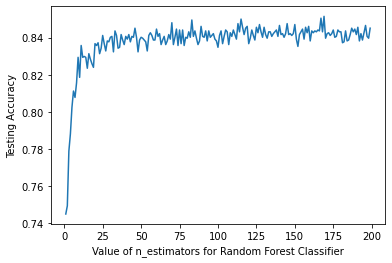

In [45]:
#For a basic RandomForestClassifier, it will be useful to see where n_estimators tapers out
X = model_df.loc[:, model_df.columns != 'home_team_won']
y = model_df.loc[:, model_df.columns == 'home_team_won']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=0)

scores =[]
for k in range(1, 200):
    rfc = RandomForestClassifier(n_estimators=k)
    rfc.fit(X_train, y_train)
    y_pred = rfc.predict(X_test)
    scores.append(accuracy_score(y_test, y_pred))

import matplotlib.pyplot as plt
%matplotlib inline

# plot the relationship between K and testing accuracy
# plt.plot(x_axis, y_axis)
plt.plot(range(1, 200), scores)
plt.xlabel('Value of n_estimators for Random Forest Classifier')
plt.ylabel('Testing Accuracy')

In [46]:
def get_best_params(model_df, clf, param_grid):
    X = model_df.loc[:, model_df.columns != 'home_team_won']
    y = model_df.loc[:, model_df.columns == 'home_team_won']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=0)

    pipeline= Pipeline([('scaler',RobustScaler()),('clf',clf)])
    pipeline.fit(X_train,y_train)

    #Predicting y for X_val
    y_pred = pipeline.predict(X)

    number_models=5
    
    m_class=RandomizedSearchCV(estimator=pipeline['clf'], param_distributions=param_grid, n_iter=number_models,
                             scoring='accuracy', n_jobs=2, cv=5, refit=True, return_train_score=True, random_state=0)

    m_class.fit(X_train,y_train)
    predictions=m_class.predict(X_test)
    
    a_score = accuracy_score(y_test,predictions)
    best_params = m_class.best_params_
    b_score = m_class.best_score_
    
    print("Accuracy Score:",accuracy_score(y_test,predictions))
    print("Best params:",m_class.best_params_)
    print("Best score:",m_class.best_score_)
    
    return a_score, best_params, b_score

In [47]:
model = LogisticRegression(random_state=0)

lr_parameter_grid = {'penalty':['l1','l2','elasticnet','none'],
                     'C':[0,0.5,1],
                     'solver':['liblinear','lbfgs','sag','saga']}

lr_acc, lr_par, lr_bs = get_best_params(model_df, model, lr_parameter_grid)

Accuracy Score: 0.865686274509804
Best params: {'solver': 'liblinear', 'penalty': 'l1', 'C': 1}
Best score: 0.85896581854328


In [48]:
model = RandomForestClassifier(random_state=0)

rfc_parameter_grid={'n_estimators':[50,75,100,125,150],
                    'criterion':['entropy','gini'],
                    'max_depth':[8,10,12,14],
                    'min_samples_leaf': [1,2,3,4],
                    'max_features':[10,15,20,25,30]}

rfc_acc, rfc_par, rfc_bs = get_best_params(model_df, model, rfc_parameter_grid)

Accuracy Score: 0.8338235294117647
Best params: {'n_estimators': 150, 'min_samples_leaf': 2, 'max_features': 15, 'max_depth': 12, 'criterion': 'gini'}
Best score: 0.8373909116658383


In [49]:
model = xgb.XGBClassifier()

xgb_parameter_grid={'booster':['gbtree','gblinear'],
                    'eta':[0.2,0.3,0.5,0.7],
                    'max_depth':[6,10,15],
                    'lambda':[0,0.5,1,2],
                    'alpha':[0,0.5,1,2]
                   }

xgb_acc, xgb_par, xgb_bs = get_best_params(model_df, model, xgb_parameter_grid)

Accuracy Score: 0.8514705882352941
Best params: {'max_depth': 10, 'lambda': 0.5, 'eta': 0.5, 'booster': 'gbtree', 'alpha': 0.5}
Best score: 0.8465443113740454


In [50]:
def make_prediction(df, model, test_size=0.25, random_state=0):
    X = df.loc[:, df.columns != 'home_team_won']
    y = df.loc[:, df.columns == 'home_team_won']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state=random_state)
    
    sc = RobustScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    
    clf = model.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    pred_proba = clf.predict_proba(X_test)
    
    #evals
    pred_score = clf.score(X_test, y_test)
    cm=confusion_matrix(y_test,y_pred)
    
    
    return pred_proba, y_test, pred_score, cm

In [51]:
lr_model = LogisticRegression(solver='liblinear',penalty='l1',C=1,random_state=0)
rfc_model = RandomForestClassifier(n_estimators=150, min_samples_leaf= 2, max_features= 15, max_depth= 12, criterion= 'gini')
xgb_model = xgb.XGBClassifier(max_depth= 10, reg_lambda= 0.5, eta= 0.5, booster= 'gbtree', alpha= 0.5)

In [52]:
lr_pred_proba, lr_y_test, lr_score, lr_cm = make_prediction(model_df, lr_model)

In [53]:
rfc_pred_proba, rfc_y_test, rfc_score, rfc_cm = make_prediction(model_df, rfc_model)

In [54]:
xgb_pred_proba, xgb_y_test, xgb_score, xgb_cm = make_prediction(model_df, xgb_model)

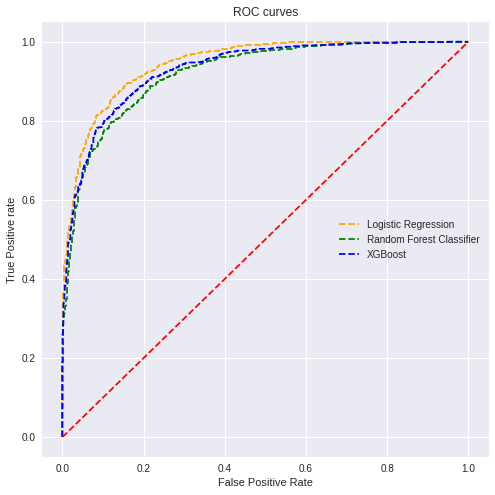

In [55]:
plt.style.use('seaborn')
# roc curve for models
lr_fpr, lr_tpr, lr_thresh = roc_curve(lr_y_test, lr_pred_proba[:,1], pos_label=1)
rfc_fpr, rfc_tpr, rfc_thresh = roc_curve(rfc_y_test, rfc_pred_proba[:,1], pos_label=1)
xgb_fpr, xgb_tpr, xgb_thresh = roc_curve(xgb_y_test, xgb_pred_proba[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(lr_y_test))]
p_fpr, p_tpr, _ = roc_curve(lr_y_test, random_probs, pos_label=1)

# auc scores
lr_auc_score = roc_auc_score(lr_y_test, lr_pred_proba[:,1])
rfc_auc_score = roc_auc_score(rfc_y_test, rfc_pred_proba[:,1])
xgb_auc_score = roc_auc_score(xgb_y_test, xgb_pred_proba[:,1])
   
# plot roc curves
plt.figure(figsize=(8,8))
plt.plot(lr_fpr, lr_tpr, linestyle='--',color='orange', label='Logistic Regression',)
plt.plot(rfc_fpr, rfc_tpr, linestyle='--',color='green', label='Random Forest Classifier')
plt.plot(xgb_fpr, xgb_tpr, linestyle='--',color='blue', label='XGBoost')
plt.plot(p_fpr, p_tpr, linestyle='--', color='red')
plt.title('ROC curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='right');

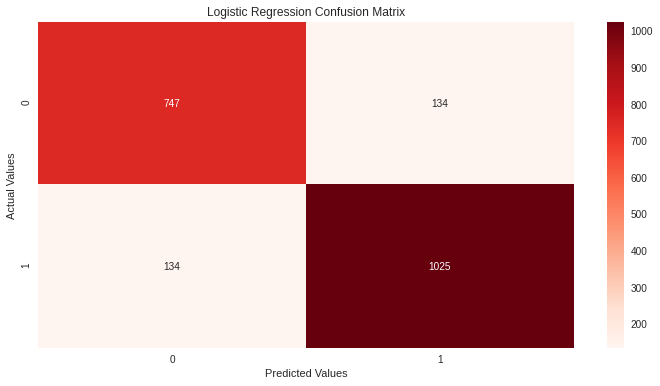

In [56]:
#Logistic Regression Confusion Matrix
plt.figure(figsize=(12,6))
plt.title("Logistic Regression Confusion Matrix")
sns.heatmap(lr_cm, annot=True,fmt='d', cmap='Reds')
plt.ylabel("Actual Values")
plt.xlabel("Predicted Values");

### Make Predictions

In [57]:
lr_model = LogisticRegression(solver='liblinear',penalty='l1',C=1,random_state=0)
rfc_model = RandomForestClassifier(n_estimators=150, min_samples_leaf= 2, max_features= 15, max_depth= 12, criterion= 'gini')
xgb_model = xgb.XGBClassifier(max_depth= 10, reg_lambda= 0.5, eta= 0.5, booster= 'gbtree', alpha= 0.5)

In [58]:
def make_2023_prediction(df_train, df_predict, model, test_size=0.25, random_state=0):
    X = df_train.loc[:, df_train.columns != 'home_team_won']
    y = df_train.loc[:, df_train.columns == 'home_team_won']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state=random_state)
    
    sc = RobustScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    
    clf = model.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    pred_score = clf.score(X_test, y_test)
    
    print('Model accuracy score:',pred_score)
    
    print('Running model on 2023 data...')
    prediction_list = sc.transform(df_predict.values.tolist())
    predictions_2023 = clf.predict(prediction_list)
    
    print('Model complete!')
    
    return pred_score, predictions_2023

In [59]:
pred_score, predictions_2023 = make_2023_prediction(model_df, df_2023, lr_model, test_size=0.25, random_state=0)



Model accuracy score: 0.8686274509803922
Running model on 2023 data...
Model complete!


In [60]:
def create_final_df(df, predictions):
    
    #add predictions columns per team
    df['prediction'] = predictions
    df['away_prediction'] = 1-df['prediction']
    df = df[['home_team_id','away_team_id','prediction','away_prediction']]
    
    #add team ids, clean table
    df = df.merge(team_ids,how='left', left_on='home_team_id', right_on='id'
                 ).merge(team_ids,how='left', left_on='away_team_id', right_on='id'
                        ).rename(columns={'full_name_x':'home_team','full_name_y':'away_team'})
    
    #create home wins df and away wins df, aggregate by team
    home_wins = df.groupby('home_team').agg({'prediction':sum}).reset_index()
    away_wins = df.groupby('away_team').agg({'away_prediction':sum}).reset_index()
    
    #merge home and away dfs for total wins column
    total_wins = home_wins.merge(away_wins,how='left',left_on='home_team',right_on='away_team')
    total_wins['total_wins'] = total_wins['prediction']+total_wins['away_prediction']
    
    #add conference details, drop irrelevant columns
    final_df = total_wins[['home_team','total_wins']].merge(teams[['full_name','conference']],how='left', left_on='home_team', right_on='full_name'
                                                       ).drop(columns={'home_team'}).sort_values(by='total_wins', ascending=False)
    
    #return final df in desired order
    return final_df[['full_name','conference','total_wins']].reset_index(drop=True)


In [61]:
final_df = create_final_df(df_2023, predictions_2023)

In [62]:
final_df.head()

,full_name,conference,total_wins
0,Golden State Warriors,West,74
1,Boston Celtics,East,66
2,Milwaukee Bucks,East,61
3,Utah Jazz,West,60
4,Toronto Raptors,East,58


## Based on our model, which teams per conference will make the Finals?

Time for the final part of our supervised learning portion! Let's see who our model is predicting will make it to the finals for each conference...

In [63]:
west = final_df[final_df.conference=='West'].head(8)
east = final_df[final_df.conference=='East'].head(8)

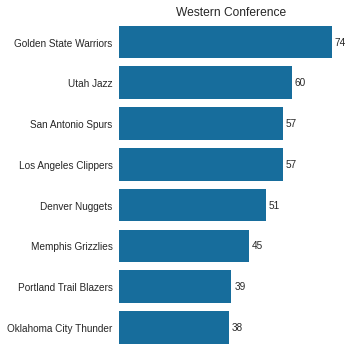

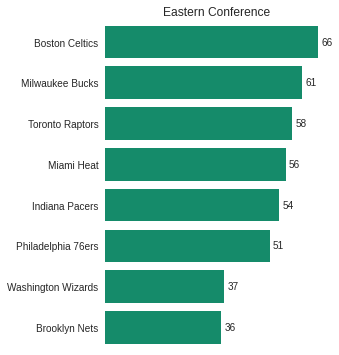

In [64]:
# Initialize figure
f, ax = plt.subplots(figsize=(4, 6))

# Plot the total wins
sns.set_color_codes("colorblind")
sns.barplot(x="total_wins", y="full_name", data=west, color="b")

# Add number of wins next to bars
for p in ax.patches:
    width = p.get_width()
    ax.text(width + 1,
            p.get_y() + p.get_height() / 2,
            '{:1.0f}'.format(width),
            ha = 'left',
            va = 'center')

# Clean up chart
plt.box(on=None)
plt.xlabel("")
plt.ylabel("")
ax.get_xaxis().set_visible(False)
plt.title("Western Conference");

# Initialize figure
f, ax = plt.subplots(figsize=(4, 6))

# Plot the total wins
sns.set_color_codes("colorblind")
sns.barplot(x="total_wins", y="full_name", data=east, color="g")

# Add number of wins next to bars
for p in ax.patches:
    width = p.get_width()
    ax.text(width + 1,
            p.get_y() + p.get_height() / 2,
            '{:1.0f}'.format(width),
            ha = 'left',
            va = 'center')

# Clean up chart
plt.box(on=None)
plt.xlabel("")
plt.ylabel("")
ax.get_xaxis().set_visible(False)
plt.title("Eastern Conference");

### Opinion

Well, as a fan of the NBA, I'd say that some of these teams will very likely make it into the top 8 per conference, BUT some of the teams on this list don't make sense at all, at least in my opinion! There are many limitations to this model. To name a few...
<ol>
    <li>2023 Prediction Input: we're using the 7-year average per team when stacked against a given team. Teams change every year, and we definitely didn't factor in trades. Will the Utah Jazz even make the top 8 in the Western conference, given the trades that had this summer? We likely should have considered a model that used a weighted average and/or made adjustments based on major trades.</li>
    <li>Injuries: Teams experience injuries that ruin a team's chances of doing well. What would happen if Giannis Antetokounmpo had a career-ending injury? Would the Milwaukee Bucks make the Finals?</li>
    <li>Just plain bad predictions: As a fan of the NBA, I just don't expect San Antonio Spurs to make the top 8 in the Western Conference at all. Same for the Washington Wizards or Indiana Pacers in the Eastern Conference. If we had more time, we'd assess which features are skewing these team's number of wins. I'd additionally reconsider using the team 7-year stat averages as input for how each team will perform in 2023.</li>
</ol>

However, at the end of the day, I am generally happy with how the model looks. It doesn't look to unrealistic, but I don't know if I'd put money behind my predictions without putting more time into my models! Overall, this is a great start.